In [1]:
# pip install torch==2.3.0 torchvision==0.18.0

In [70]:
import torch
import pandas as pd
import numpy as np
from scipy.stats import mannwhitneyu, fisher_exact
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('data/FGF14_pb_may_22.csv', delimiter=';', header=0)
print(df.head())

In [ ]:
column_names = pd.DataFrame(df.columns, columns = ['Names'])
print(column_names.to_string(index=False))

In [ ]:
counts = []

for column in df.columns:
    num_unique_values = df[column].nunique()
    counts.append([column, num_unique_values])

counts = pd.DataFrame(counts, columns=['Variable', 'Number_Unique'])
print(counts.to_string(index=False))

In [ ]:
def categorize_var(number_unique):
    if number_unique <= 2:
        return "Binary"
    elif number_unique == 3:
        return "Group"
    else:
        return "Continuous"
    
counts['Variable_Type'] = counts['Number_Unique'].apply(categorize_var)
counts.at[0, 'Variable_Type'] = 'ID'
print(counts.to_string(index=False))

In [ ]:
continuous_vars = counts[counts['Variable_Type'] == 'Continuous']['Variable'].tolist()
binary_vars = counts[counts['Variable_Type'] == 'Binary']['Variable'].tolist()
print(df.shape, len(continuous_vars), len(binary_vars))  

In [ ]:
columns_to_subset = ['genetics_conclusion'] + continuous_vars
df_continuous = df[columns_to_subset].copy()
df_continuous[continuous_vars] = df_continuous[continuous_vars].apply(pd.to_numeric, errors='coerce')
df_continuous

In [8]:
def calculate_stats_continuous(df, subset_column, subset_value):
    subset_df = df[df[subset_column] == subset_value]
    summary_stats_data = []

    for column in subset_df.columns:
        if pd.api.types.is_numeric_dtype(subset_df[column]):  
            mean = subset_df[column].mean()
            sd = subset_df[column].std()
            summary_stats_data.append({'Column': column, 'Mean': mean, 'SD': sd})

    summary_stats_df = pd.DataFrame(summary_stats_data)
    summary_stats_df['Mean ± SD'] = summary_stats_df.apply(lambda row: f"{row['Mean']:.2f} ± {row['SD']:.2f}", axis=1)
    summary_stats_df.drop(['Mean', 'SD'], axis=1, inplace=True)
    return summary_stats_df

In [135]:
result_FGF = calculate_stats_continuous(df_continuous, 'genetics_conclusion', 'FGF')
result_Neg = calculate_stats_continuous(df_continuous, 'genetics_conclusion', 'Negative')
result_MSA = calculate_stats_continuous(df_continuous, 'genetics_conclusion', 'MSA')

result_FGF.to_csv('data/result_FGF_cont.csv')
result_Neg.to_csv('data/result_Neg_cont.csv')
result_MSA.to_csv('data/result_MSA_cont.csv')

### **Summary Binary Features**

In [ ]:
columns_to_subset = ['genetics_conclusion'] + binary_vars
df_binary = df[columns_to_subset].copy()
df_binary[binary_vars] = df_binary[binary_vars].apply(pd.to_numeric, errors='coerce')
df_binary

In [10]:
def calculate_stats_binary(df, subset_column, subset_value):
    subset_df = df[df[subset_column] == subset_value]
    summary_stats_data = []

    for column in subset_df.columns:
        if pd.api.types.is_numeric_dtype(subset_df[column]) and subset_df[column].nunique() <= 2:
            sum_ = subset_df[column].sum()
            percentage = (sum_ / len(subset_df)) * 100
            summary_stats_data.append({'Column': column, 'Sum': sum_, 'Percentage': percentage})

    summary_stats_df = pd.DataFrame(summary_stats_data)
    summary_stats_df['n (%%)'] = summary_stats_df.apply(lambda row: f"{row['Sum']} ({row['Percentage']:.2f}%)", axis=1)
    summary_stats_df.drop(['Sum', 'Percentage'], axis=1, inplace=True)

    return summary_stats_df

In [146]:
result_FGF = calculate_stats_binary(df_binary, 'genetics_conclusion', 'FGF')
result_Neg = calculate_stats_binary(df_binary, 'genetics_conclusion', 'Negative')
result_MSA = calculate_stats_binary(df_binary, 'genetics_conclusion', 'MSA')

result_FGF.to_csv('data/result_FGF_bin.csv')
result_Neg.to_csv('data/result_Neg_bin.csv')
result_MSA.to_csv('data/result_MSA_bin.csv')

### **Mann Whitney U**

In [11]:
def perform_mann_whitney(df, continuous_columns, condition_column, g_1, g_2 ):
    results = []
    
    for col in continuous_columns:
        try:
            group_1 = df[df[condition_column] == g_1][col].dropna()
            group_2 = df[df[condition_column] == g_2][col].dropna()
            _, p_value = mannwhitneyu(group_1, group_2, alternative='two-sided')
            results.append((col, p_value.round(4)))

        except Exception as e:
            print(f"Error occurred for column '{col}': {e}")
            continue

    results_df = pd.DataFrame(results, columns=['Column', 'P-Value'])
    return results_df

In [ ]:
mann_whit_fgf_neg = perform_mann_whitney(df_continuous, continuous_vars, 'genetics_conclusion', 'FGF', 'Negative')
mann_whit_fgf_msa = perform_mann_whitney(df_continuous, continuous_vars, 'genetics_conclusion', 'FGF', 'MSA')

mann_whit_fgf_neg.to_csv('data/mann_whit_fgf_neg.csv')
mann_whit_fgf_msa.to_csv('data/mann_whit_fgf_msa.csv')

### **Fisher's Exact**

In [12]:
def perform_fishers_exact(df, binary_columns, condition_column, g_1, g_2):
    results = []
    
    filtered_df = df[(df[condition_column] == g_1) | (df[condition_column] == g_2)]

    for col in binary_columns:
        try:
            group_1 = filtered_df[filtered_df[condition_column] == g_1][col]
            group_2 = filtered_df[filtered_df[condition_column] == g_2][col]
            
            if not (group_1.sum() == 0 and group_2.sum() == 0):
                contingency_table = pd.crosstab(filtered_df[condition_column], filtered_df[col])
                odds_ratio, p_value = fisher_exact(contingency_table)
                p_value = round(p_value, 4)
                results.append((col, p_value))
        except Exception as e:
            print(f"Error occurred for column '{col}': {e}")
            continue

    results_df = pd.DataFrame(results, columns=['Column', 'P-Value'])
    
    return results_df

In [ ]:
fisher_fgf_neg = perform_fishers_exact(df_binary, binary_vars, 'genetics_conclusion', 'FGF', 'Negative')
fisher_fgf_msa = perform_fishers_exact(df_binary, binary_vars, 'genetics_conclusion', 'MSA', 'Negative')

fisher_fgf_neg = fisher_fgf_neg.rename(columns={"P-Value": "P-Value_Neg"})
fisher_fgf_msa = fisher_fgf_msa.rename(columns={"P-Value": "P-Value_MSA"})

merged_df = pd.merge(fisher_fgf_neg, fisher_fgf_msa, on='Column', how='left')
merged_df
merged_df.to_csv('data/merged_df.csv')

### **XGBoost FGF+ vs FGF-**

In [357]:
df = pd.read_csv('data/FGF14_pb_may_22.csv', delimiter=';', header=0)
df.drop(['patient_id', 'date_of_birth'], axis=1, inplace=True)

In [358]:
missing_columns_bool = df.isnull().any()

In [ ]:
filtered_df = df[ (df['genetics_conclusion'] == 'FGF') | (df['genetics_conclusion'] == 'Negative') ]
filtered_df

In [360]:
missing_columns_bool = df.isnull().any()

In [ ]:
filtered_df.isnull().sum().sort_values(ascending=False)

In [ ]:
filtered_df = filtered_df[['genetics_conclusion']  + binary_vars ].copy()
filtered_df.isnull().sum().sort_values(ascending=False)

In [363]:
filtered_df.drop([ 'dx_GERD',
         'dx_eye_disease', 'dx_rheumatological_disease',
         'epi_diplopia', 'epi_dysarthria' , 'epi_gait_balance_impair', 
         'epi_oscillospsia', 'epi_tremor', 'epi_vertigo' , 'epi_visual_impair', 
         'SCA_excluded', 'FRDA_excluded', 'NGS_panel_exome', 'fragile_x', 'EA', 'RFC1',
         'GFAP', 'C90RF72', 'HTT', 'fragile_x', 'SPG', 'ATM',
         'perm_constipation', 'perm_diplopia', 'perm_dysarthria', 'perm_dysesthesia', 'perm_erectile_dysf', 'perm_gait_balance_impair',
         'perm_handwriting_impair', 'perm_oscillopsia', 'perm_pseudobulbar_affect', 'perm_tremor', 'perm_urinary_dysf', 'perm_urinary_incont',
         'perm_vertigo', 'perm_visual_impair'], axis=1, inplace=True)

In [ ]:
filtered_df.isnull().sum().sort_values(ascending=False)

In [365]:
filtered_df['genetics_conclusion'] = filtered_df['genetics_conclusion'].apply(lambda x: 1 if x == 'FGF' else 0)

In [366]:
y = filtered_df['genetics_conclusion']
X = filtered_df.drop(columns=['genetics_conclusion'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
model = xgboost.XGBClassifier(n_estimators=142, max_depth=2, objective = "binary:logistic").fit(X, y)
model.fit(X_train, y_train)

In [368]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")


Accuracy: 0.75


In [369]:
explainer = shap.Explainer(model, X)
shap_values = explainer(X)
shap_values.display_data = X.values

In [370]:
def rgba_to_hex(rgba):
    """Convert RGBA color code to hexadecimal color code."""
    r, g, b, a = rgba
    return "#{:02X}{:02X}{:02X}".format(int(r * 255), int(g * 255), int(b * 255))

cmap = plt.get_cmap('RdBu')
blue_hex = rgba_to_hex(cmap(0.0))
red_hex = rgba_to_hex(cmap(1.0))
print(red_hex, blue_hex)

#053061 #67001F


In [382]:

shap.initjs()
shap.force_plot(shap_values[23], plot_cmap=["#053061", "#67001F"])
#1,2,3,7, 11,15
#23,24,25;28,32,35,

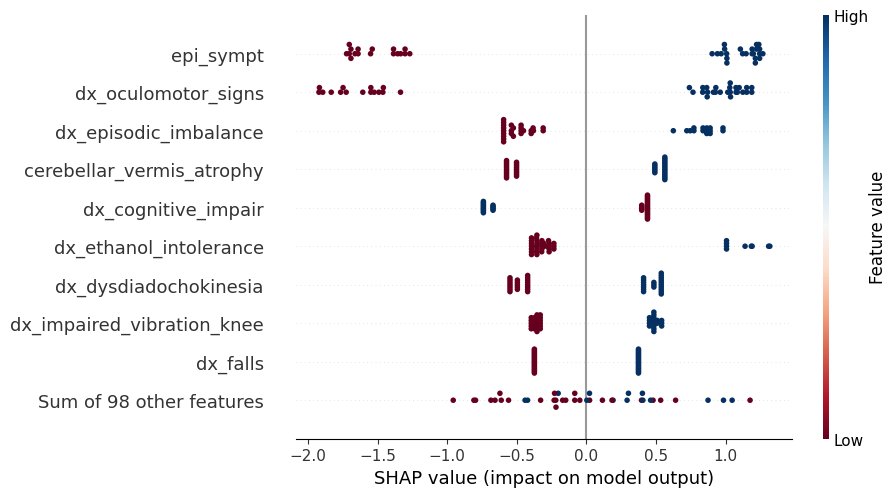

In [372]:
shap.plots.beeswarm(shap_values,  color=plt.get_cmap("RdBu"))

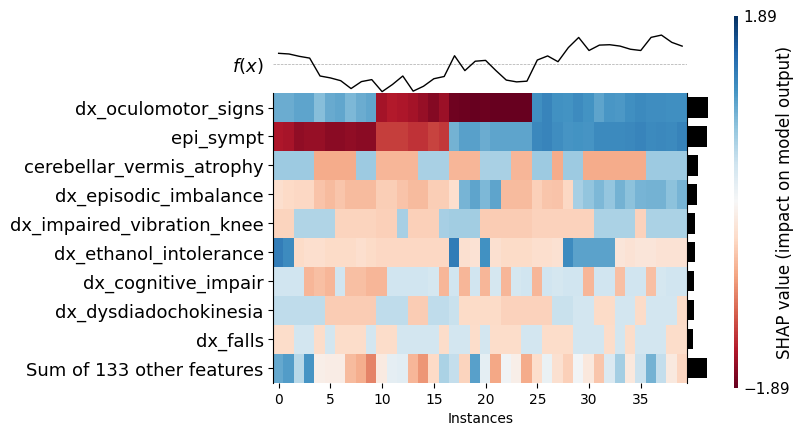

In [157]:
shap.plots.heatmap(shap_values, max_display=10, plot_width=6, cmap=plt.get_cmap("RdBu"))

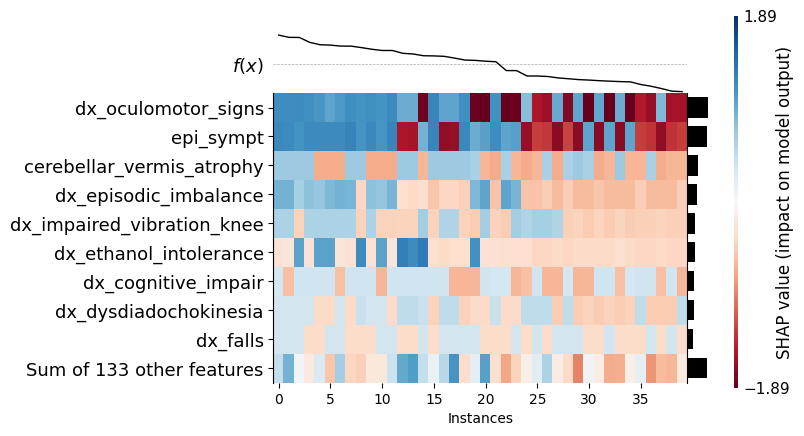

In [206]:
shap.plots.heatmap(shap_values, max_display=10, plot_width=6, instance_order=shap_values.sum(1), cmap=plt.get_cmap("RdBu"))

### **XGBoost FGF+ vs MSA**

In [326]:
df = pd.read_csv('data/FGF14_pb_may_22.csv', delimiter=';', header=0)
df.drop(['patient_id', 'date_of_birth'], axis=1, inplace=True)

In [327]:
missing_columns_bool = df.isnull().any()

In [ ]:
filtered_df = df[ (df['genetics_conclusion'] == 'FGF') | (df['genetics_conclusion'] == 'MSA') ]
filtered_df

In [329]:
missing_columns_bool = df.isnull().any()

In [ ]:
filtered_df.isnull().sum().sort_values(ascending=False)

In [ ]:
filtered_df = filtered_df[['genetics_conclusion']  + binary_vars ].copy()
filtered_df.isnull().sum().sort_values(ascending=False)

In [333]:
filtered_df.drop([ 'dx_GERD',
         'dx_eye_disease', 'dx_rheumatological_disease',
         'epi_diplopia', 'epi_dysarthria' , 'epi_gait_balance_impair', 
         'epi_oscillospsia', 'epi_tremor', 'epi_vertigo' , 'epi_visual_impair', 
         'SCA_excluded', 'FRDA_excluded', 'NGS_panel_exome', 'fragile_x', 'EA', 'RFC1',
         'GFAP', 'C90RF72', 'HTT', 'fragile_x', 'SPG', 'ATM',
         'perm_constipation', 'perm_diplopia', 'perm_dysarthria', 'perm_dysesthesia', 'perm_erectile_dysf', 'perm_gait_balance_impair',
         'perm_handwriting_impair', 'perm_oscillopsia', 'perm_pseudobulbar_affect', 'perm_tremor', 'perm_urinary_dysf', 'perm_urinary_incont',
         'perm_vertigo', 'perm_visual_impair'], axis=1, inplace=True)

In [334]:
filtered_df['genetics_conclusion'] = filtered_df['genetics_conclusion'].apply(lambda x: 1 if x == 'FGF' else 0)

In [335]:
y = filtered_df['genetics_conclusion']
X = filtered_df.drop(columns=['genetics_conclusion'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
model = xgboost.XGBClassifier(n_estimators=142, max_depth=2, objective = "binary:logistic").fit(X, y)
model.fit(X_train, y_train)

In [337]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.88


In [338]:
explainer = shap.Explainer(model, X)
shap_values = explainer(X)
shap_values.display_data = X.values

In [339]:
def rgba_to_hex(rgba):
    """Convert RGBA color code to hexadecimal color code."""
    r, g, b, a = rgba
    return "#{:02X}{:02X}{:02X}".format(int(r * 255), int(g * 255), int(b * 255))

cmap = plt.get_cmap('RdBu') # cmap(#) returns list with rgba
blue_hex = rgba_to_hex(cmap(0.0))
red_hex = rgba_to_hex(cmap(1.0))
print(red_hex, blue_hex)

#053061 #67001F


In [356]:
shap.initjs()
shap.force_plot(shap_values[2], plot_cmap=["#053061", "#67001F"])
# 1,2,4,5,6;9;10,11;19
# 22 24 25 29 31

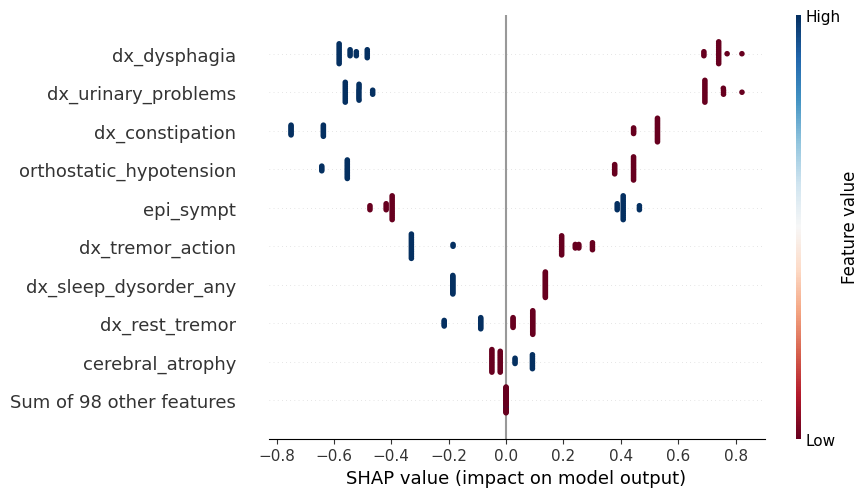

In [340]:
shap.plots.beeswarm(shap_values,  color=plt.get_cmap("RdBu"))

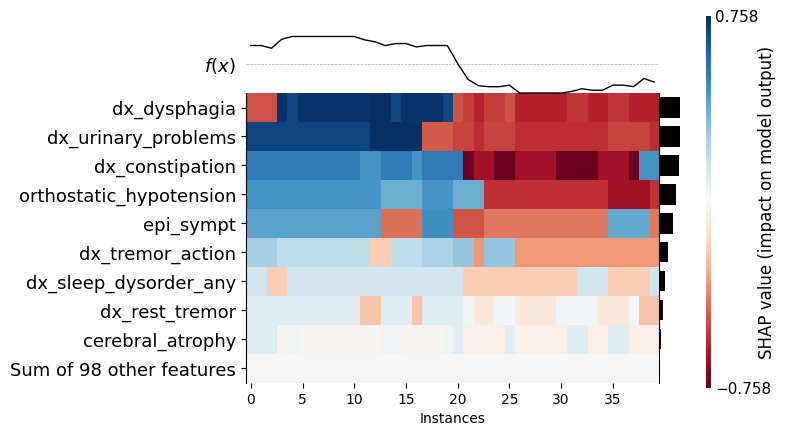

In [341]:
shap.plots.heatmap(shap_values, max_display=10, plot_width=6, cmap=plt.get_cmap("RdBu"))

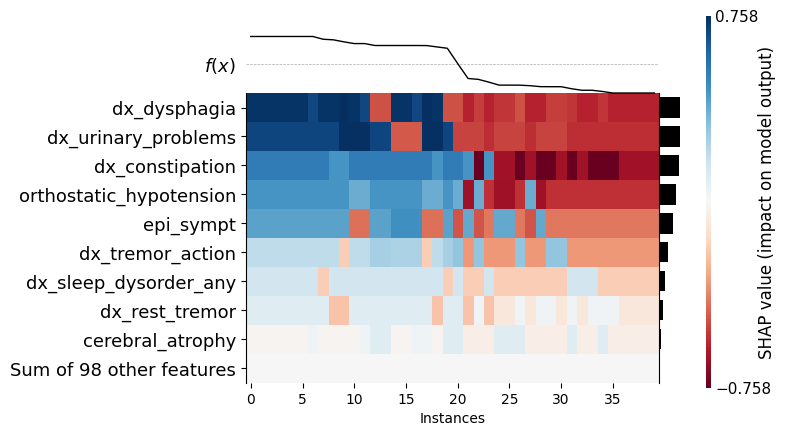

In [342]:
shap.plots.heatmap(shap_values, max_display=10, plot_width=6, instance_order=shap_values.sum(1), cmap=plt.get_cmap("RdBu"))

In [311]:
np.exp(-3)/(1+np.exp(-3))


0.04742587317756679